In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences

nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("wordnet")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sarvo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarvo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarvo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
H_s = pd.read_csv("Stress.csv")
H_s.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [3]:
H_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [4]:
H_s['subreddit'].unique()

array(['ptsd', 'assistance', 'relationships', 'survivorsofabuse',
       'domesticviolence', 'anxiety', 'homeless', 'stress',
       'almosthomeless', 'food_pantry'], dtype=object)

In [5]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [6]:
wnl = WordNetLemmatizer()
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
H_s["text"] = H_s["text"].apply(remove_stopwords)

H_s["text"] = H_s["text"].apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))

Text(0.5, 1.0, 'Distribution of Labels')

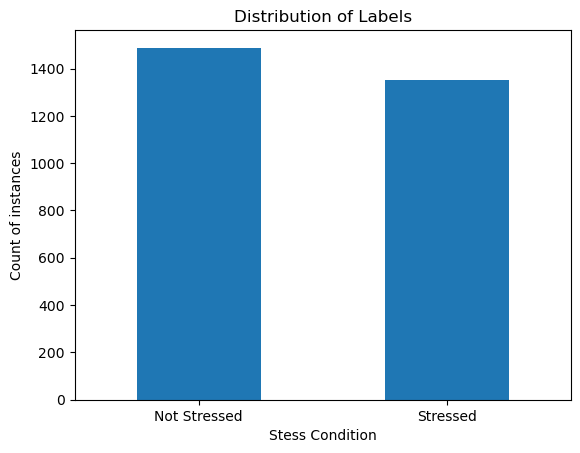

In [7]:
ax = H_s.label.value_counts().plot(kind='bar')
ax.set_xticks(ticks=[1,0],labels=['Stressed','Not Stressed'],rotation=0)
plt.ylabel('Count of instances')
plt.xlabel('Stess Condition')
plt.title('Distribution of Labels')

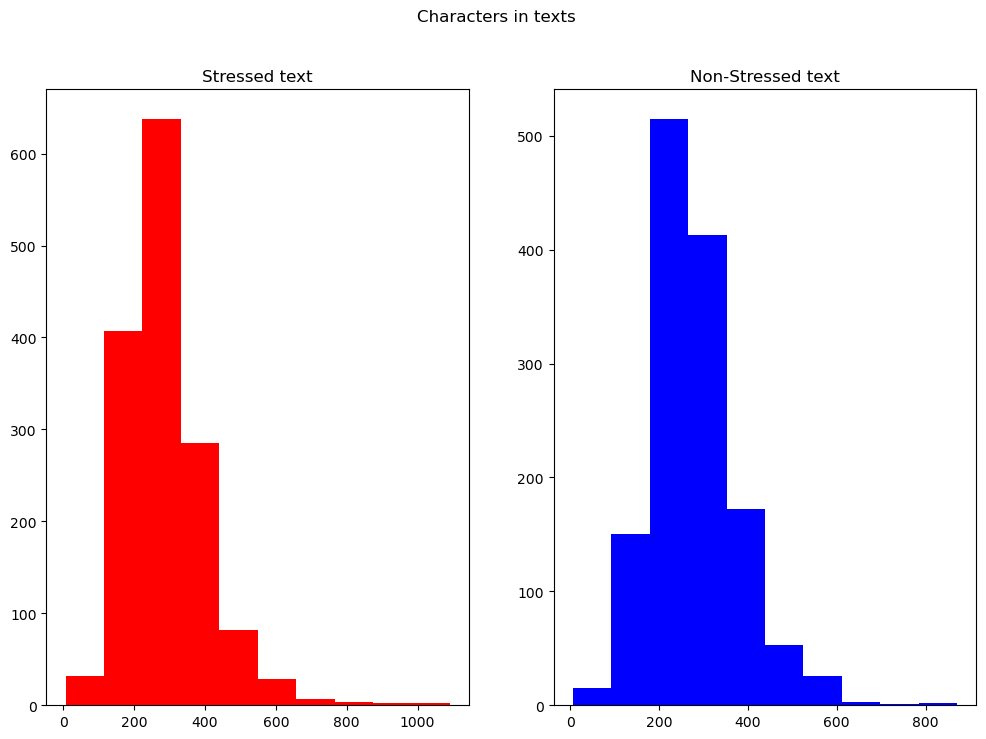

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=H_s[H_s['label']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=H_s[H_s['label']==0]['text'].str.len()
ax2.hist(text_len,color='blue')
ax2.set_title('Non-Stressed text')
fig.suptitle('Characters in texts')
plt.show()

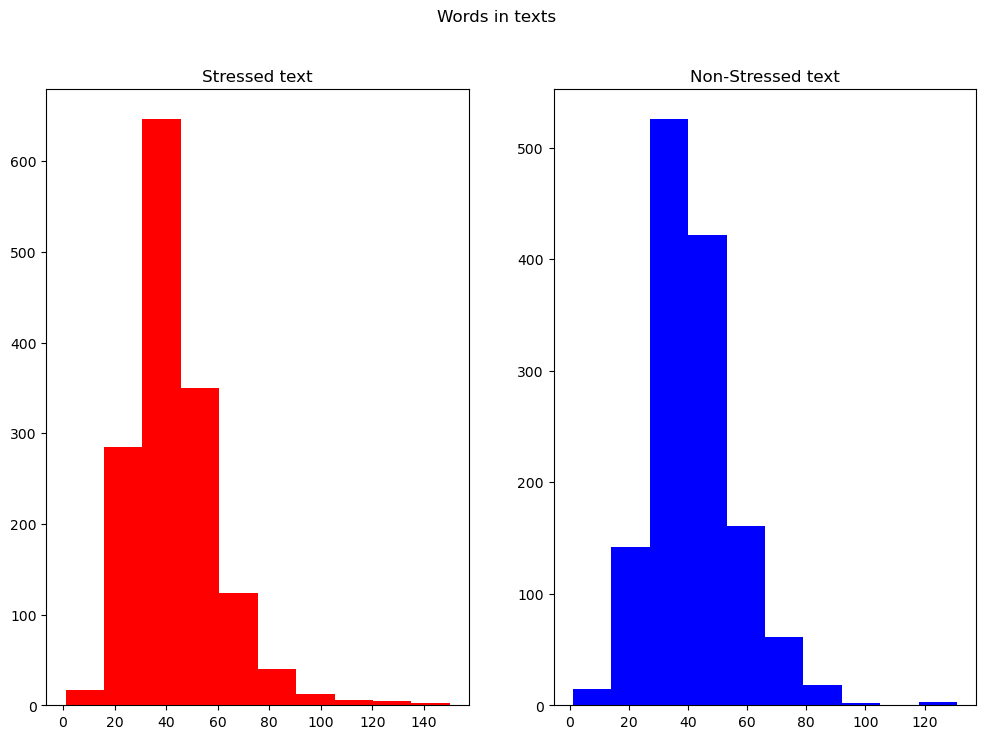

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=H_s[H_s['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Stressed text')
text_len=H_s[H_s['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='blue')
ax2.set_title('Non-Stressed text')
fig.suptitle('Words in texts')
plt.show()

For stressed

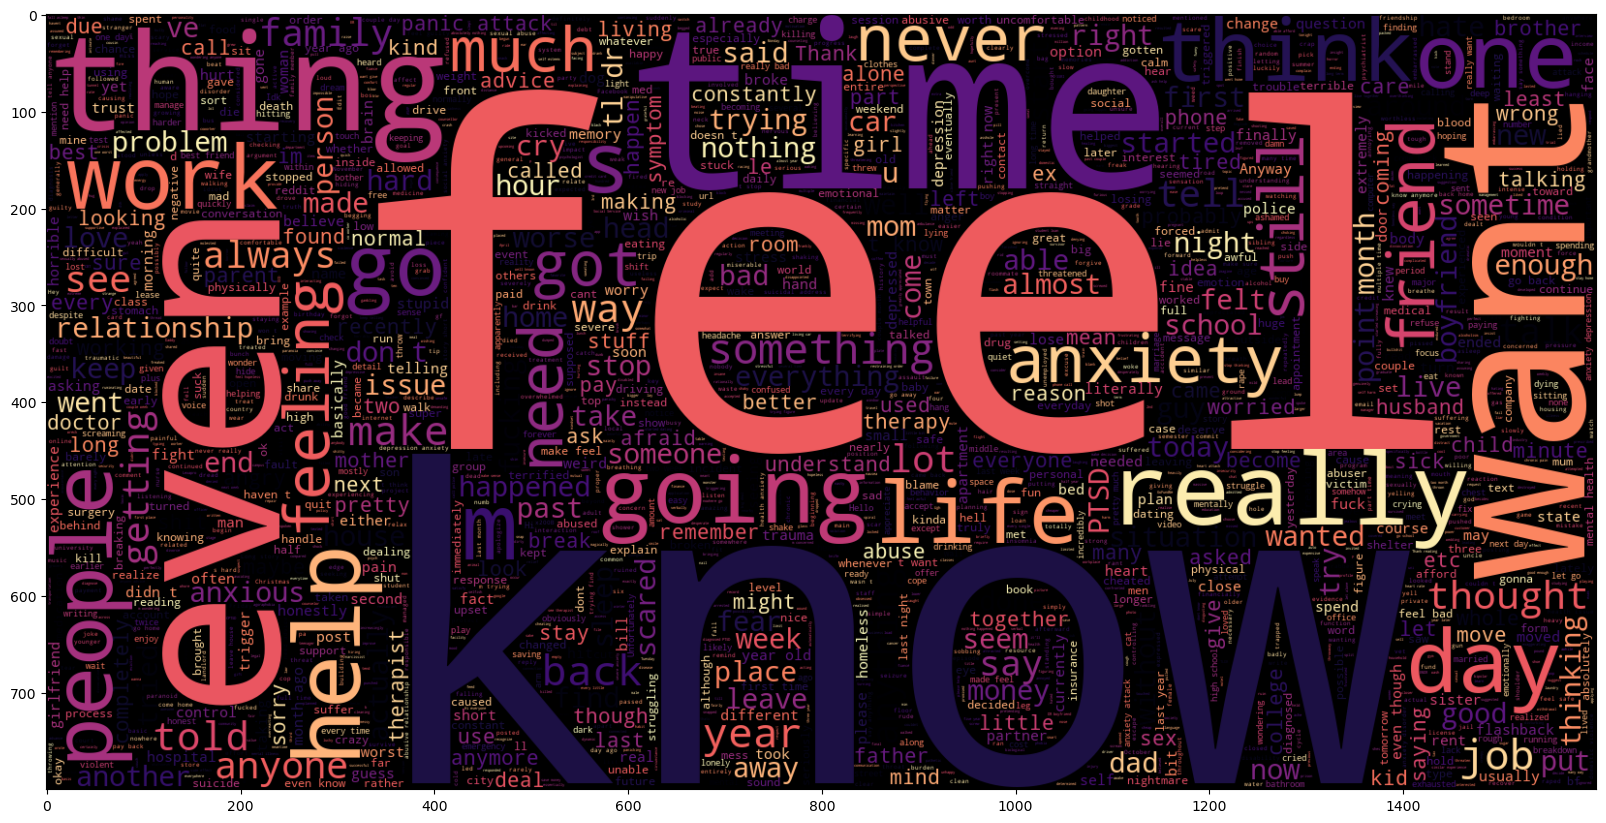

In [17]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS,colormap='magma').generate(" ".join(H_s[H_s.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

For Non-Stressed

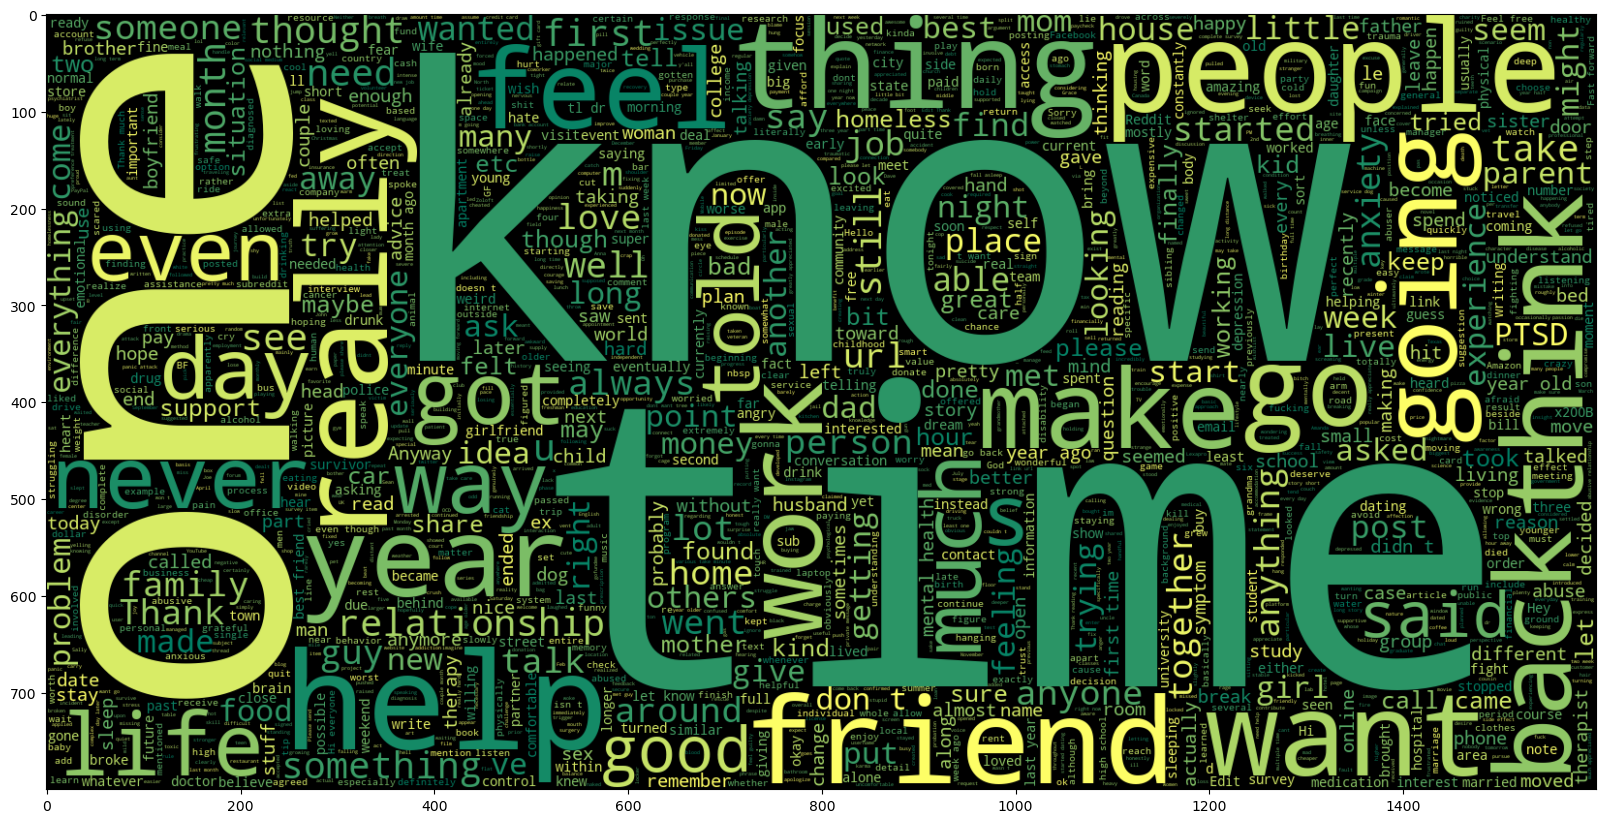

In [15]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS,colormap='summer').generate(" ".join(H_s[H_s.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [12]:
def text_clean(text_message):

    remove_punc=[ text for text in text_message if text not in string.punctuation]

    remove_punc= ''.join(remove_punc)

    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

In [13]:
H_s['text'].head(5).apply(text_clean)

0    [said, felt, way, suggeted, go, rest, TRIGGER,...
1    [Hey, rassistance, sure, right, place, post, g...
2    [mom, hit, newspaper, shocked, would, know, li...
3    [met, new, boyfriend, amazing, kind, sweet, go...
4    [October, Domestic, Violence, Awareness, Month...
Name: text, dtype: object

In [14]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
H_s["Clean_text"] = H_s["text"].apply(clean)

In [15]:
H_s["new_label"] = H_s["label"].map({0: "No Stress", 1: "Stress"})
data_H_s = H_s[["Clean_text", "new_label"]]
data_H_s.head()

,Clean_text,new_label
0,said felt way sugget go rest trigger ahead you...,Stress
1,hey rassist sure right place post go im curre...,No Stress
2,mom hit newspap shock would know like play hit...,Stress
3,met new boyfriend amaz kind sweet good student...,Stress
4,octob domest violenc awar month domest violenc...,Stress


In [16]:
symptoms_H_s = H_s[["text", "subreddit"]]
symptoms_H_s.head()

,text,subreddit
0,"said felt way before, suggeted go rest ..TRIGG...",ptsd
1,"Hey r/assistance, sure right place post this.....",assistance
2,"mom hit newspaper shocked would this, know lik...",ptsd
3,"met new boyfriend, amazing, kind, sweet, good ...",relationships
4,October Domestic Violence Awareness Month dome...,survivorsofabuse


First we will trying with different models then we will try with NLP using deep learning

In [17]:
x = np.array(data_H_s["Clean_text"])
y = np.array(data_H_s["new_label"])
cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

In [19]:
ypred = model.predict(xtest)
print(classification_report(ytest, ypred))
print(f'Accuracy: {accuracy_score(ytest,ypred )}')

              precision    recall  f1-score   support

   No Stress       0.79      0.63      0.70       444
      Stress       0.72      0.85      0.78       493

    accuracy                           0.75       937
   macro avg       0.75      0.74      0.74       937
weighted avg       0.75      0.75      0.74       937

Accuracy: 0.7459978655282817


In [20]:
from sklearn import svm
SVM = svm.SVC()
SVM.fit(xtrain,ytrain)

SVC()

In [21]:
print(classification_report(ytest,SVM.predict(xtest)))
print(f'Accuracy: {accuracy_score(ytest, SVM.predict(xtest))}')

              precision    recall  f1-score   support

   No Stress       0.69      0.72      0.70       444
      Stress       0.74      0.70      0.72       493

    accuracy                           0.71       937
   macro avg       0.71      0.71      0.71       937
weighted avg       0.71      0.71      0.71       937

Accuracy: 0.7118463180362861


In [22]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(xtrain,ytrain)

DecisionTreeClassifier(random_state=0)

In [23]:
print(classification_report(ytest,DTC.predict(xtest)))
print(f'Accuracy: {accuracy_score(ytest, DTC.predict(xtest))}')

              precision    recall  f1-score   support

   No Stress       0.58      0.55      0.56       444
      Stress       0.61      0.63      0.62       493

    accuracy                           0.60       937
   macro avg       0.59      0.59      0.59       937
weighted avg       0.59      0.60      0.59       937

Accuracy: 0.5955176093916755


In [24]:
from sklearn.naive_bayes import MultinomialNB
MN = MultinomialNB()
MN.fit(xtrain,ytrain)

MultinomialNB()

In [25]:
print(classification_report(ytest,MN.predict(xtest)))
print(f'Accuracy: {accuracy_score(ytest, MN.predict(xtest))}')

              precision    recall  f1-score   support

   No Stress       0.81      0.60      0.69       444
      Stress       0.71      0.88      0.78       493

    accuracy                           0.75       937
   macro avg       0.76      0.74      0.74       937
weighted avg       0.76      0.75      0.74       937

Accuracy: 0.7459978655282817


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(H_s['text'], H_s['label'], test_size=0.20, random_state=42)

In [28]:
X_train_nlp=X_train_nlp.apply(text_clean)
X_test_nlp= X_test_nlp.apply(text_clean)

In [29]:
vocab_size=50000
embedding_dim=96
max_length=2000
trunc_type='post'
oov_tok="<oov>"

In [30]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_nlp)
word_index = tokenizer.word_index

train_seqs = tokenizer.texts_to_sequences(X_train_nlp)
train_padded = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)

test_seqs = tokenizer.texts_to_sequences(X_test_nlp)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

In [31]:
model_nlp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(72, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_nlp.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_nlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 96)          4800000   
                                                                 
 global_average_pooling1d (  (None, 96)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 72)                6984      
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 4807057 (18.34 MB)
Trainable params: 4807057 (18.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
num_epochs = 50

history_dl = model_nlp.fit(
    train_padded,
    y_train_nlp,
    epochs=num_epochs,
    validation_data=(test_padded, y_test_nlp)
    )

Epoch 1/50
71/71 [==============================] - 10s 132ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6906 - val_accuracy: 0.5370
Epoch 2/50
71/71 [==============================] - 9s 134ms/step - loss: 0.6928 - accuracy: 0.5211 - val_loss: 0.6906 - val_accuracy: 0.5370
Epoch 3/50
71/71 [==============================] - 9s 127ms/step - loss: 0.6927 - accuracy: 0.5211 - val_loss: 0.6908 - val_accuracy: 0.5370
Epoch 4/50
71/71 [==============================] - 9s 124ms/step - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.6906 - val_accuracy: 0.5370
Epoch 5/50
71/71 [==============================] - 9s 125ms/step - loss: 0.6918 - accuracy: 0.5211 - val_loss: 0.6911 - val_accuracy: 0.5370
Epoch 6/50
71/71 [==============================] - 9s 123ms/step - loss: 0.6921 - accuracy: 0.5159 - val_loss: 0.6898 - val_accuracy: 0.5370
Epoch 7/50
71/71 [==============================] - 9s 125ms/step - loss: 0.6918 - accuracy: 0.5211 - val_loss: 0.6901 - val_accuracy: 0.5370
Epoch

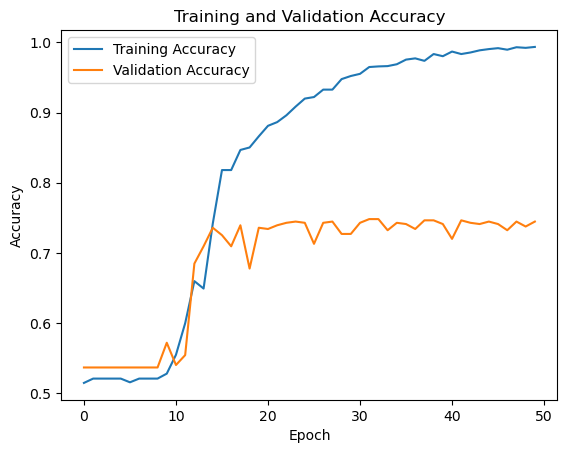

Final Training Accuracy: 0.9933920502662659
Final Validation Accuracy: 0.7447183132171631


In [33]:

plt.plot(history_dl.history['accuracy'], label='Training Accuracy')
plt.plot(history_dl.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

final_train_accuracy = history_dl.history['accuracy'][-1]
final_val_accuracy = history_dl.history['val_accuracy'][-1]
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(H_s['text'], H_s['label'], test_size=0.20, random_state=42)

In [35]:
max_features=1000
maxlen=300

In [36]:
tokenizer=text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train=tokenizer.texts_to_sequences(x_train)
x_train=pad_sequences(tokenized_train,maxlen=maxlen)

In [37]:
x_test = [str(x) for x in x_test]

In [38]:
tokenized_test=tokenizer.texts_to_sequences(x_test)
x_test=pad_sequences(tokenized_test,maxlen=maxlen)

In [39]:
EMBEDDING_FILE='glove.twitter.27B.100d.txt'

In [40]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'
with open(EMBEDDING_FILE, 'r', encoding='utf-8') as file:
    embeddings_index = dict(get_coefs(*o.rsplit(' ')) for o in file)

In [41]:
all_embs=np.stack(embeddings_index.values())
emb_mean,emb_std=all_embs.mean(),all_embs.std()
embed_size=all_embs.shape[1]

word_index=tokenizer.word_index
nb_words=min(max_features,len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [42]:
batch_size=256
epochs=10
embed_size=100

In [43]:
learning_rate=ReduceLROnPlateau(monitor='val_accuracy',
                                patirnce=2,verbose=1,factor=-.5,min_lr=0.00001)

In [44]:
model_LSTM=Sequential()
model_LSTM.add(Embedding(max_features,output_dim=embed_size,weights=[embedding_matrix],
                    input_length=maxlen,trainable=False))
model_LSTM.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model_LSTM.add(LSTM(units=64,recurrent_dropout=0.1,dropout=0.1))
model_LSTM.add(Dense(units=32,activation='relu'))
model_LSTM.add(Dense(1,activation='sigmoid'))
model_LSTM.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [45]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 268769 (1.03 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 100000 (390.62 KB)
_________________________________________________________________


In [46]:
history=model_LSTM.fit(x_train,y_train,batch_size=batch_size,
                  validation_data=(x_test,y_test),epochs=epochs,
                  callbacks=[learning_rate])

Epoch 1/10
9/9 [==============================] - 115s 12s/step - loss: 0.6631 - accuracy: 0.5969 - val_loss: 0.6325 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 2/10
9/9 [==============================] - 118s 13s/step - loss: 0.5927 - accuracy: 0.6872 - val_loss: 0.5874 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - 116s 13s/step - loss: 0.5450 - accuracy: 0.7233 - val_loss: 0.5849 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 4/10
9/9 [==============================] - 118s 13s/step - loss: 0.5426 - accuracy: 0.7269 - val_loss: 0.5712 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 5/10
9/9 [==============================] - 119s 13s/step - loss: 0.5377 - accuracy: 0.7256 - val_loss: 0.5657 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 6/10
9/9 [==============================] - 123s 14s/step - loss: 0.5116 - accuracy: 0.7405 - val_loss: 0.5613 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 7/10
9/9 [==============================] - 123s 14s/step - loss: 0.5193 - a

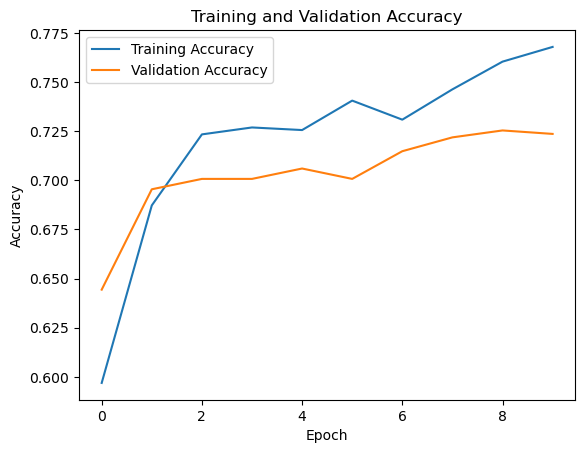

Final Training Accuracy: 0.7678413987159729
Final Validation Accuracy: 0.7235915660858154


In [47]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)

In [66]:
max_length = 2000
sentence = ['Recently, I\'ve been incredibly overburdened. It\'s difficult for me to breathe, and my heart races irrationally. I find it difficult to focus on anything, and even minor tasks seem to be piling up. I often have trouble falling asleep at night because my mind continues going over my problems. Even my favorite pastimes are no longer enjoyable for me because I have lost my appetite. On edge and as though something horrible is going to happen, I sometimes feel',
           'I\'ve been feeling a little aggravated lately. I seem to be more sensitive to little irritations than usual.',
           'I\'ve been incredibly anxious and restless. It seems like my mind is constantly running and I can\'t sit still.'
           'At night, I\'ve been having difficulties sleeping. My mind won\'t stop churning, and I struggle to find some peace.',
           'My jaw has been clenched a lot lately, I\'ve noticed. Perhaps I\'m just anxious about work.',
           'I\'ve been experiencing extreme fatigue and poor energy. Even rising from the bed in the morning is difficult.',
           'I\'ve been finding it difficult to concentrate on my work. I feel like my memory is jumbled and I frequently forget stuff.',
           'I am doing my work and currently enjoying it, maybe this is the new thing now!',
           'I\'ve been enjoying my new hobby so much! It\'s a great way to relax and take my mind off things']

np_sentence=pd.Series(sentence).apply(clean)
sequences = tokenizer.texts_to_sequences(np_sentence)
padded_seqs = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

output={}
for i,seq in enumerate(padded_seqs):
    output[sentence[i]]=model_nlp.predict(np.array([seq]))[0]
output = pd.DataFrame.from_dict(output, orient='index', columns=['prediction'])
output.index.name = 'sentence'
output=output.reset_index()
print(output)

1/1 [==============================] - 0s 18ms/step
                                            sentence  prediction
0  Recently, I've been incredibly overburdened. I...    0.999332
1  I've been feeling a little aggravated lately. ...    0.689071
2  I've been incredibly anxious and restless. It ...    0.807400
3  My jaw has been clenched a lot lately, I've no...    0.398356
4  I've been experiencing extreme fatigue and poo...    0.333584
5  I've been finding it difficult to concentrate ...    0.871634
6  I am doing my work and currently enjoying it, ...    0.271722
7  I've been enjoying my new hobby so much! It's ...    0.285507
